In [ ]:
# Configuration - change these to analyze different periods
REPORT_YEAR = 2026
REPORT_MONTH = 2
COMPARISON_YEAR = 2025
COMPARISON_MONTH = 2

# Month names for display
MONTH_NAMES = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

print(f"Report Period: {MONTH_NAMES[REPORT_MONTH]} {REPORT_YEAR}")
print(f"Comparison Period: {MONTH_NAMES[COMPARISON_MONTH]} {COMPARISON_YEAR}")

Report Period: December 2025
Comparison Period: December 2022


In [2]:
from IPython.display import Markdown, display
display(Markdown(f"# Data Quality Report for {MONTH_NAMES[REPORT_MONTH]} {REPORT_YEAR}"))

# Data Quality Report for December 2025

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, "..")
from helpers.aws import execute_athena_query

sns.set_theme()

# Calculate date range for report month
report_start = f"{REPORT_YEAR}-{REPORT_MONTH:02d}-01"
next_month = REPORT_MONTH + 1 if REPORT_MONTH < 12 else 1
next_year = REPORT_YEAR if REPORT_MONTH < 12 else REPORT_YEAR + 1
report_end = f"{next_year}-{next_month:02d}-01"

sql = f"""
with site_names as (
    select distinct site_name 
    from lake.weather 
    where year = {REPORT_YEAR} and month = {REPORT_MONTH}
),

periods as (
    select distinct date(observation_ts) as ts 
    from lake.weather 
    where year = {REPORT_YEAR} and month = {REPORT_MONTH}
),

expected_chunks as (select distinct * from periods, site_names)

select * from (
    select ec.site_name, ec.ts, count(w.temperature) as num_temp_readings 
    from expected_chunks ec
    left outer join lake.weather w 
        on w.site_name = ec.site_name 
        and date(observation_ts) = ec.ts
        and w.year = {REPORT_YEAR}
        and w.month = {REPORT_MONTH}
    group by ec.ts, ec.site_name
)
where ts >= date('{report_start}') and ts < date('{report_end}')
order by site_name, ts asc
"""

results_url = execute_athena_query(sql, "lake", "dantelore.queryresults")
df = pd.read_csv(results_url)
df['day'] = pd.to_datetime(df['ts']).dt.strftime('%d')


# Hourly readings collected per day this month

This table shows the number of hourly readings gathered per day for each weather station in the dataset.

In [4]:
hex_colors = sns.color_palette("RdYlGn", 25).as_hex()
def cell_colour(x):
    try:
        i = int(x)
    except (ValueError, TypeError):
        return ""

    return f"background-color: {hex_colors[i]}" 

table = df.pivot(index='site_name', columns='day', values='num_temp_readings')

table.style.map(cell_colour)


day,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
site_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABERDARON,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ABERDEEN AIRPORT,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ABERPORTH,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ABOYNE,24,19,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ALBEMARLE,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ALTNAHARRA SAWS,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
ANDREWSFIELD,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
AONACH MOR SUMMIT,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24
AULTBEA,24,23,24,24,24,24,24,24,24,24,23,24,24,24,24,24,24,23,24,24,24,24,24,24,24,24,24,24,24,23,24


In [5]:
# Calculate date ranges
comparison_start = f"{COMPARISON_YEAR}-{COMPARISON_MONTH:02d}-01"
comp_next_month = COMPARISON_MONTH + 1 if COMPARISON_MONTH < 12 else 1
comp_next_year = COMPARISON_YEAR if COMPARISON_MONTH < 12 else COMPARISON_YEAR + 1
comparison_end = f"{comp_next_year}-{comp_next_month:02d}-01"

sql_this_period = f"""
select observation_ts, temperature 
from lake.weather
where year = {REPORT_YEAR} and month = {REPORT_MONTH}
  and observation_ts >= date('{report_start}') 
  and observation_ts < date('{report_end}')
"""

sql_comparison_period = f"""
select observation_ts, temperature 
from lake.weather
where year = {COMPARISON_YEAR} and month = {COMPARISON_MONTH}
  and observation_ts >= date('{comparison_start}') 
  and observation_ts < date('{comparison_end}')
"""

results_url = execute_athena_query(sql_this_period, "lake", "dantelore.queryresults")
this_month = pd.read_csv(results_url)
this_month['day'] = pd.to_datetime(this_month['observation_ts']).dt.strftime('%d')
this_month['temperature'] = pd.to_numeric(this_month['temperature'], errors='coerce')

results_url = execute_athena_query(sql_comparison_period, "lake", "dantelore.queryresults")
comparison_month = pd.read_csv(results_url)
comparison_month['day'] = pd.to_datetime(comparison_month['observation_ts']).dt.strftime('%d')
comparison_month['temperature'] = pd.to_numeric(comparison_month['temperature'], errors='coerce')


KeyboardInterrupt: 

# This Month vs Last Year

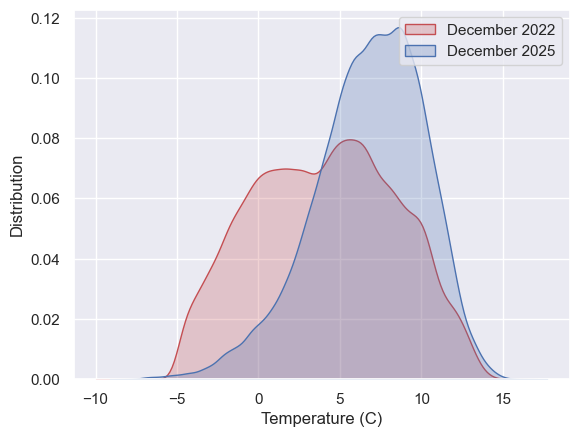

In [ ]:
sns.set_theme(style="darkgrid")

comparison_label = f"{MONTH_NAMES[COMPARISON_MONTH]} {COMPARISON_YEAR}"
report_label = f"{MONTH_NAMES[REPORT_MONTH]} {REPORT_YEAR}"

sns.kdeplot(data=comparison_month, x="temperature", fill=True, color="r", label=comparison_label)
sns.kdeplot(data=this_month, x="temperature", fill=True, color="b", label=report_label)

plt.xlabel('Temperature (C)', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.legend(loc='upper right')
plt.show()